## Demonstrating functions for Taylor scale project

This notebook demonstrates the construction of the final dataset for the Taylor scale project. Each row of the dataset is a 6-hour period of the solar wind as measured by the Wind spacecraft, and each column is a quantity or parameter of the solar wind for this period. The two parameters we are most interested are the *correlation scale* and *Taylor scale*. Both scales are calculated from the autocorrelation function, and both require some thought as to what technique to use to calculate them.

Previously, **Kevin de Lange** created an equivalent dataset and investigated the correlation between the Taylor scale and the other variables, including training machine learning models to predict the Taylor scale. *He found an unexpected, reasonably strong positive correlation between the Taylor scale and correlation scale*. Specifically, he found a **correlation of 0.77 between the Taylor scale and exponential-fit correlation scale**, and **0.62 between the Taylor scale and the 1/e-trick correlation scale**.                                                                 

We are now more rigorously estimating the Taylor scale to confirm or deny this correlation.

### Notes
- The interval used to demonstrate the pipeline is not ideal in that its ACF lacks the desired parabolic shape near the origin and overall exponential shape. However, it is still a useful demonstration given that not all ACFs will have this nice shape.
- Scales are returned in units of seconds
- For demonstration purposes, `plot=True` arguments in functions assume a solar wind speed of 400km/s. The specific speeds measured for each interval are used in the actual analysis. 
- We expect slight variation from Kevin's numbers due to using a cadence of 11Hz instead of 10Hz.

### To-do

1. Check latest pipeline with Tulasi
2. Put into functions in .py script/s, and test pipeline on two months of data (Jan-Feb 2016), using importlib.reload
2. From this, reconstruct Fig. 5.1 from Kevin's report
2. Check with Tulasi
2. Run pipeline on full five (+?) years of data
3. Plot normalised time series of the scales
4. Compute correlation matrix and potentially cross-correlation of the scales

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm
import astropy.units as u
from astropy.table import Table

while ".toplevel" not in os.listdir():
    os.chdir("..")

from utils import pipeline, print_cdf_info, join_dataframes_on_timestamp, read_cdf

#### Reading in Omni data

6-hour averages, first processed and saved to `.pkl` file by `process_data_omni.py`

In [2]:
df_omni = pd.read_pickle("data/processed/omni_6hr.pkl")
df_omni.columns = df_omni.columns.str.lower()
df_omni = df_omni.rename(
    columns={
        'proton_density':'proton_density_omni',
        't':'temperature',
        'beta':'plasma_beta',  
        'e':'electric_field',  
        'pressure':'flow_pressure'})
df_omni.describe()

,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,7.629370,88446.203125,415.195892,1.876287,2.352355,0.788729
std,5.309639,79275.312500,84.458252,1.285798,1.254984,0.686382
min,1.501792,10210.652344,268.823608,0.062431,0.421444,0.076406
25%,4.092863,36289.657227,353.235924,1.120479,1.582026,0.368339
50%,6.067542,67387.437500,396.871201,1.559008,2.029808,0.579917
75%,9.312843,113806.886719,464.271729,2.189879,2.754799,0.924743
max,32.507652,647744.625000,629.847229,10.137687,8.122097,5.598134


Demonstrating use of Units features from `astropy` package (not currently used)

In [3]:
# Can also use QTable objet for smarter behaviour

omni_table = Table.from_pandas(df_omni.reset_index())
omni_table.add_index("Timestamp")
omni_table["proton_density_omni"] = omni_table["proton_density_omni"] /u.centimeter**3
omni_table["temperature"] = omni_table["temperature"] * u.K
omni_table["flow_speed"] = omni_table["flow_speed"] * u.km /u.s
omni_table["flow_pressure"] = omni_table["flow_pressure"] * u.nPa
omni_table["electric_field"] = omni_table["electric_field"] * u.mV / u.m
omni_table

Timestamp,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field
,1 / cm3,K,km / s,,nPa,mV / m
Time,float32,float32,float32,float32,float32,float32
2016-01-01T00:00:00.000,1.631,36290.113,440.6396,0.062430553,0.6377778,5.5981336
2016-01-01T06:00:00.000,1.5017917,93113.06,433.80737,0.15568055,0.56744444,1.8359413
2016-01-01T12:00:00.000,1.5283611,65383.055,413.84946,0.16506945,0.526625,0.51565593
2016-01-01T18:00:00.000,6.850236,67298.86,428.87918,3.348236,2.5828333,0.22773333
2016-01-02T00:00:00.000,4.9039583,37046.176,435.6075,1.1712917,1.8568333,0.33030832
2016-01-02T06:00:00.000,9.205305,51438.324,464.40695,3.5429862,3.9783473,0.71381944
2016-01-02T12:00:00.000,6.7342362,101419.13,468.51,4.2503057,2.9624305,0.54421264
2016-01-02T18:00:00.000,5.9459324,98407.68,458.27396,1.4523365,2.4973006,0.3363788


Checking for missing values

In [4]:
df_omni.isna().any()

proton_density_omni    False
temperature            False
flow_speed             False
plasma_beta            False
flow_pressure          False
electric_field         False
dtype: bool

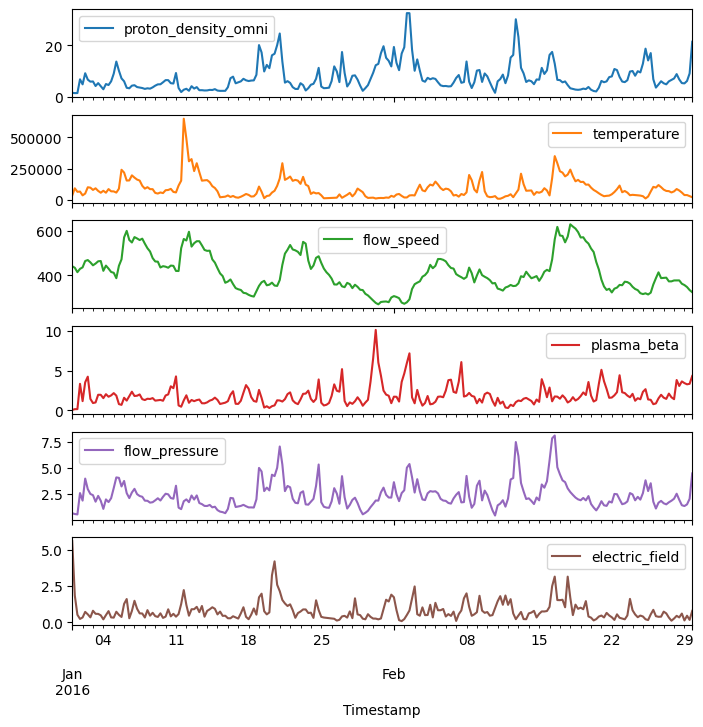

In [5]:
df_omni.plot(subplots=True, figsize=(8,8))
plt.show()

### Reading in Wind data

#### Electron data
6-hour averages, first processed and saved to `.pkl` file in `process_data_wind_electrons.py`

In [6]:
df_electrons = pd.read_pickle('data/processed/wi_elm2_3dp_6hr.pkl')
df_electrons.columns = df_electrons.columns.str.lower()
df_electrons = df_electrons.rename(
    columns={
        'density':'electron_density_wind', # n/cc
        'avgtemp':'electron_temperature', # eV
        'velocity_0':'electron_velocity_0', # km/s
        'velocity_1':'electron_velocity_1',
        'velocity_2':'electron_velocity_2'})
df_electrons.describe()

,electron_density_wind,electron_temperature,electron_velocity_0,electron_velocity_1,electron_velocity_2
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,3.505369,14.045693,-528.744507,58.350426,-28.723679
std,1.667939,2.611206,56.718494,20.462563,20.049084
min,0.636881,9.328401,-650.537354,-1.827031,-92.456978
25%,2.539840,11.813660,-575.421310,48.042364,-34.712104
50%,3.114274,14.666605,-509.333969,59.122490,-27.079688
75%,3.888707,15.567647,-485.213432,68.278288,-21.535178
max,9.831376,23.853952,-404.157928,124.091782,17.562920


In [7]:
# Checking for missing values
df_electrons.isna().any()

electron_density_wind    False
electron_temperature     False
electron_velocity_0      False
electron_velocity_1      False
electron_velocity_2      False
dtype: bool

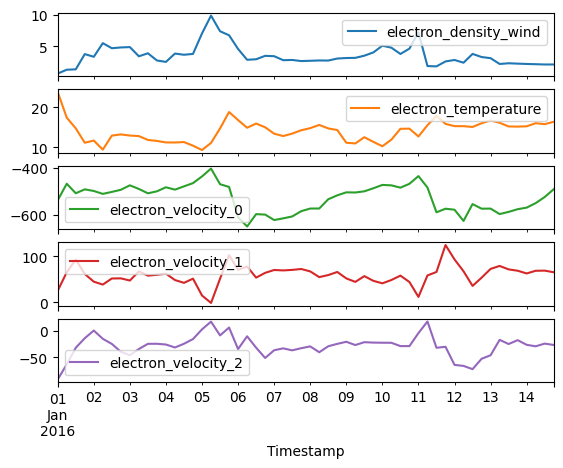

In [8]:
df_electrons.plot(subplots=True)
plt.show()

#### Proton data

6-hour averages, first processed and saved to `.pkl` file in `process_data_omni.py`

In [9]:
df_protons = pd.read_pickle("data/processed/wi_plsp_3dp_6hr.pkl")
df_protons.columns = df_protons.columns.str.lower()
df_protons = df_protons.rename(
    columns={
        'mom.p.density':'proton_density_wind',
        'mom.p.avgtemp':'proton_temperature',
        'mom.p.velocity_0':'proton_velocity_0',
        'mom.p.velocity_1':'proton_velocity_1',
        'mom.p.velocity_2':'proton_velocity_2'})
df_protons.describe()

,proton_density_wind,proton_temperature,proton_velocity_0,proton_velocity_1,proton_velocity_2
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,4.299490,19.907368,-495.726440,17.454563,-6.304993
std,2.192486,10.241973,57.281078,16.057425,18.129818
min,1.316161,9.789320,-624.581421,-25.493786,-46.306183
25%,2.748313,12.984211,-546.765137,11.398095,-16.259240
50%,4.050215,15.395069,-477.466751,17.909070,-7.285550
75%,5.093310,24.222755,-451.767342,26.155148,2.577097
max,13.190617,53.153130,-398.106445,65.315598,35.991684


In [10]:
# Checking for missing values
df_protons.isna().any()

proton_density_wind    False
proton_temperature     False
proton_velocity_0      False
proton_velocity_1      False
proton_velocity_2      False
dtype: bool

Now that we have the proton density from Wind (assuming this is better to use than that from OMNI for the same time period), we can calculate the ion inertial length $d_i$. This can be thought of as the thickness of the current sheets that form in turbulent plasma, and will be used as one method of calculating the Reynolds number of the solar wind. It may also help us to identify the slope of the dissipation range, required for Chuychai's method of obtaining refined estimates of the Taylor scale.

$$d_i=c/\omega_{i}=V_A/\Omega_I=2.28\times10^2\times\frac{\sqrt{\mu/n_i}}{Z} \text{km}$$
- $c$ is the speed of light
- $\omega_{i}$ is the (local) ion plasma frequency
- $V_A$ is the Alfven speed
- $\Omega_i$ is the ion gyrofrequency
- $\mu$ is the ratio of the ion mass to proton mass
- $n_i$ is the ion number density
- $Z$ is the charge state

For protons, this reduces to 

$$d_i=2.28\times10^2\times\sqrt{1/n_i} \text{km}$$

This should be in the range of 100-200km @ 1AU


In [11]:
df_protons["ion_inertial_length"] = ((df_protons.proton_density_wind)**-0.5)*2.28e2
df_protons[["ion_inertial_length"]].describe()

,ion_inertial_length
count,52.000000
mean,119.387543
std,28.322565
min,62.777252
25%,101.026512
50%,113.291420
75%,137.533691
max,198.737747


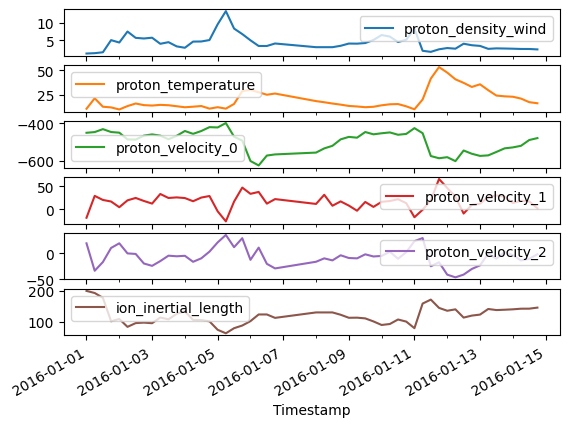

In [12]:
df_protons.plot(subplots=True)
plt.show()

#### Magnetic field data

##### 11Hz data
(Resampled to dt = 0.091s)

In [13]:
large_wind_df_hr = pd.read_pickle("data/processed/wi_h2_mfi_hr.pkl")
large_wind_df_hr.describe().round(2)

,BF1,BGSE_0,BGSE_1,BGSE_2
count,13292307.00,13292307.00,13292307.00,13292307.00
mean,6.31,-0.36,0.20,0.10
std,2.26,4.02,4.12,3.40
min,0.06,-12.73,-11.22,-13.76
25%,4.81,-3.76,-2.86,-1.78
50%,5.67,-0.88,0.81,0.21
75%,7.20,3.07,3.20,2.02
max,17.15,9.88,15.79,13.10


In [14]:
# Checking for missing values
large_wind_df_hr.isna().any()

BF1       False
BGSE_0    False
BGSE_1    False
BGSE_2    False
dtype: bool

Adding magnetic field fluctuations

$$\frac{db}{B_0}=\frac{\sqrt{(B_x-\langle B_x\rangle)^2+(B_y-\langle B_y\rangle)^2+(B_z-\langle B_z\rangle)^2}}{B_0}$$

In [15]:
large_wind_df_hr["dbx"] = large_wind_df_hr["BGSE_0"] - large_wind_df_hr["BGSE_0"].mean()
large_wind_df_hr["dby"] = large_wind_df_hr["BGSE_1"] - large_wind_df_hr["BGSE_1"].mean()
large_wind_df_hr["dbz"] = large_wind_df_hr["BGSE_2"] - large_wind_df_hr["BGSE_2"].mean()
large_wind_df_hr["db"] = np.sqrt(large_wind_df_hr["dbx"]**2+large_wind_df_hr["dby"]**2+large_wind_df_hr["dbz"]**2)
large_wind_df_hr["db/B0"] = large_wind_df_hr["db"]/large_wind_df_hr["BF1"]

In [16]:
large_wind_df_hr[["db/B0"]].describe().round(2)

,db/B0
count,13292307.00
mean,0.99
std,0.06
min,0.07
25%,0.94
50%,0.98
75%,1.04
max,7.28


Taking the mean for each six-hour interval to add as a column to the final dataframe, then dropping these columns from the original df

In [17]:
turb_fluc_hr = large_wind_df_hr[["db/B0"]].resample("6H").mean()
large_wind_df_hr = large_wind_df_hr.drop(columns=["dbx", "dby", "dbz", "db", "db/B0"])

turb_fluc_hr.head()

,db/B0
Timestamp,
2016-01-01 00:00:00,1.019061
2016-01-01 06:00:00,1.028141
2016-01-01 12:00:00,1.044009
2016-01-01 18:00:00,1.058542
2016-01-02 00:00:00,1.040556


Extracting a single 6-hour interval to demonstrate the pipeline

In [18]:
wind_df_hr = large_wind_df_hr[pd.to_datetime("2016-01-01 00:00"):pd.to_datetime("2016-01-01 06:00")]
wind_df_hr.shape

(237363, 4)

In [19]:
wind_df_hr

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2016-01-01 00:00:00.000,14.943860,5.879855,-1.579370,-13.647411
2016-01-01 00:00:00.091,14.939990,5.890072,-1.591034,-13.637410
2016-01-01 00:00:00.182,14.915795,5.862018,-1.610130,-13.620763
2016-01-01 00:00:00.273,14.936459,5.875757,-1.632746,-13.634788
2016-01-01 00:00:00.364,14.943197,5.881089,-1.634825,-13.639622
...,...,...,...,...
2016-01-01 05:59:59.578,10.352386,4.167100,-9.432401,-0.914859
2016-01-01 05:59:59.669,10.335396,4.159393,-9.410312,-0.982792
2016-01-01 05:59:59.760,10.356019,4.168725,-9.420629,-1.058593


In [20]:
# Takes ~ 3min
#wind_df_hr.plot(subplots=True)

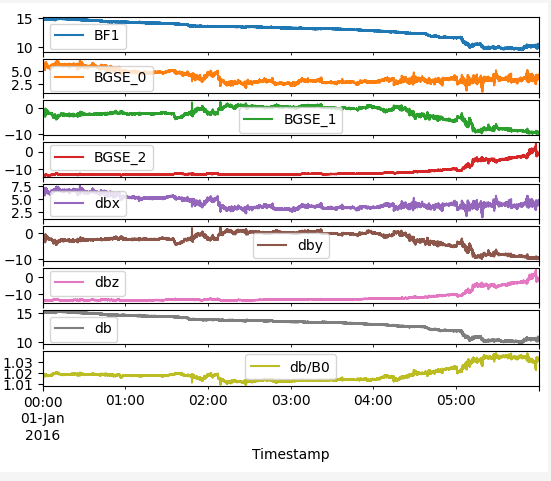

##### 0.2Hz data

In [21]:
large_wind_df_lr = pd.read_pickle("data/processed/wi_h2_mfi_lr.pkl")
large_wind_df_lr.describe()

,BF1,BGSE_0,BGSE_1,BGSE_2
count,241920.000000,241920.000000,241920.000000,241920.000000
mean,6.310163,-0.359540,0.201441,0.103327
std,2.261223,4.015538,4.113845,3.395684
min,0.122947,-12.501729,-10.827972,-13.657980
25%,4.815931,-3.755956,-2.854166,-1.775184
50%,5.673298,-0.874636,0.816870,0.214865
75%,7.199165,3.060749,3.194607,2.017385
max,16.993708,9.423657,15.568968,12.924106


Extracting a single 6-hour interval to demonstrate the pipeline

In [22]:
wind_df_lr = large_wind_df_lr[pd.to_datetime("2016-01-01 00:00"):pd.to_datetime("2016-01-01 06:00")]
wind_df_lr.shape

(4321, 4)

In [23]:
wind_df_lr

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2016-01-01 00:00:00,14.960377,5.892269,-1.597420,-13.657980
2016-01-01 00:00:05,14.943271,5.893493,-1.596435,-13.638803
2016-01-01 00:00:10,14.942538,5.841498,-1.643213,-13.654799
2016-01-01 00:00:15,14.943983,5.867721,-1.650481,-13.644319
2016-01-01 00:00:20,14.927631,5.929097,-1.638702,-13.600977
...,...,...,...,...
2016-01-01 05:59:40,10.524644,3.976334,-9.700571,-0.918856
2016-01-01 05:59:45,10.293777,3.995200,-9.434019,-0.994201
2016-01-01 05:59:50,10.398553,4.259204,-9.458218,-0.699899


Note annoying but inconsequential inclusion of 06:00:00 timestamp at the end, which will overlap with the second interval.

array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

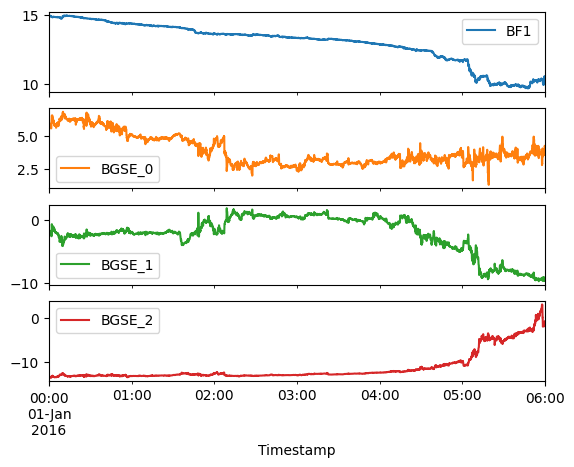

In [24]:
wind_df_lr.plot(subplots=True)

In order to fully implement Chuychai's method, we need the spectral index (slope) of the power law in the dissipation range. Here we compute a smoothed 3D periodogram for a single high-res interval, then perform a least squares fit of a power law to the inertial and kinetic ranges to determine their slopes and the spectral break.

In [25]:
# Calculate 3D power spectrum
import scipy.signal as signal

def SmoothySpec(a,nums=None):
   """Smooth a curve using a moving average smoothing"""
   b=a.copy()
   if nums is None: nums=2*len(b)//3
   for i in range(nums):
      b[i+1:-1] = 0.25*b[i:-2]+0.5*b[i+1:-1]+0.25*b[i+2:]
   return b

def fitpowerlaw(ax,ay,xi,xf):
   idxi=np.argmin(abs(ax-xi))
   idxf=np.argmin(abs(ax-xf))
   xx=np.linspace(xi,xf,100)
   z=np.polyfit(np.log(ax[idxi:idxf]),np.log(ay[idxi:idxf]),1);
   p=np.poly1d(z);
   pwrl=np.exp(p(np.log(xx)))
   return z,xx,pwrl

def compute_spectral_stats(np_array, dt, f_min_inertial, f_max_inertial, f_min_kinetic, f_max_kinetic, di = None, velocity = None,show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    ### Args:

    - np_array: Array of shape (1,n) or (3,n)
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds
    - di: (Optional, only used for plotting) Ion inertial length in km
    - velocity: (Optional, only used for plotting) Solar wind velocity in km/s
    - corr_scale: (Optional, only used for plotting) Correlation scale (seconds)
    - taylor_scale: (Optional, only used for plotting) Taylor scale (seconds)
    ### Returns:

    - z_i: Slope in the inertial range
    - z_k: Slope in the kinetic range
    - spectral_break: Frequency of the spectral break between the two ranges

    """
    x_freq = 1/dt

    f_periodogram, power_periodogram_0 = signal.periodogram(np_array[0], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_0 = (x_freq/2)*power_periodogram_0

    f_periodogram, power_periodogram_1 = signal.periodogram(np_array[1], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_1 = (x_freq/2)*power_periodogram_1

    f_periodogram, power_periodogram_2 = signal.periodogram(np_array[2], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_2 = (x_freq/2)*power_periodogram_2

    power_periodogram = (power_periodogram_0 + power_periodogram_1 + power_periodogram_2)/3

    p_smooth = SmoothySpec(power_periodogram) # Slowest part of this function - takes ~ 10 seconds

    zk, xk, pk = fitpowerlaw(f_periodogram, p_smooth, f_min_kinetic, f_max_kinetic) # Kinetic range
    zi, xi, pi = fitpowerlaw(f_periodogram, p_smooth, f_min_inertial, f_max_inertial) # Inertial range

    powerlaw_intersection = np.roots(zk-zi)
    spectral_break = np.exp(powerlaw_intersection)

    if show == True:
        plt.semilogy(f_periodogram, power_periodogram, label = "Raw periodogram")
        plt.semilogy(f_periodogram, p_smooth, label = "Smoothed periodogram", color = "cyan")
        plt.semilogy(xi, pi, c = "red", label = "Inertial range power-law fit: $\\alpha_i$ = {0:.2f}".format(zi[0]))
        plt.semilogy(xk, pk, c = "yellow", label = "Kinetic range power-law fit: $\\alpha_k$ = {0:.2f}".format(zk[0]))
        plt.semilogx()
        plt.axvline(np.exp(np.roots(zk-zi)), color = "black", label = "Spectral break: $f_d={0:.2f}$".format(spectral_break[0]))

        # Adding in proton inertial frequency
        if di is not None and velocity is not None:
            f_di = velocity/(2*np.pi*di)
            plt.axvline(f_di, color = "green", label = "Proton inertial frequency: $f_{di}=$" + "{0:.2f}".format(f_di))

        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD')
        plt.legend()
        plt.title("Power spectrum")
        plt.grid()
        plt.show()

    return zi[0], zk[0], spectral_break[0]

**Maths for calculating breakpoint:**

Each power-law fit is given by the following equation:

$$y =x^me^c$$

This is because if we take the log of both sides, we get the formula for a straight line on a log-log plot:

$$\log(y) = m\log(x)+c$$

We want to find the x-value for which the two power-laws are equal. We can do this by subtracting one from the other and finding the value of $\log(x)$ where this subtraction = 0, i.e., the root of the equation.

$$m_1\log(x)+c_1-m_2\log(x)-c_2=0$$

Finally, we take the exponential of this root to get the x-value of the spectral break

$$x = e^{\log(x)}$$

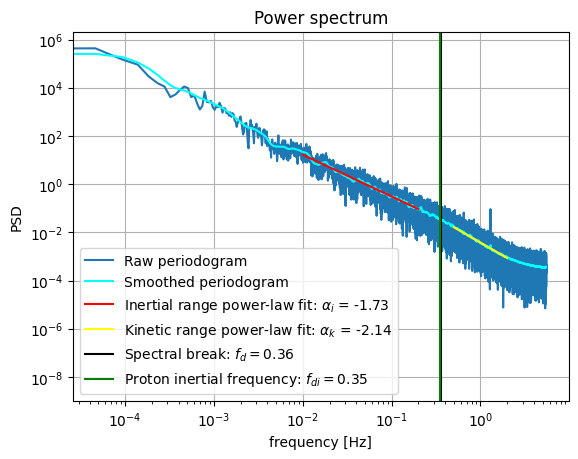

(-1.7344058323813534, -2.1353234004879957, 0.35520222609491453)

In [26]:
compute_spectral_stats(
    np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), 
    dt = 0.091, 
    f_min_inertial = 0.01, f_max_inertial = 0.2, 
    f_min_kinetic = 0.5, f_max_kinetic = 2,
    di = df_protons.loc["2016-01-01 00:00:00", "ion_inertial_length"],
    velocity = df_omni.loc["2016-01-01 00:00:00", "flow_speed"],
    show=True)

- $\alpha_{i}=-1.73$
- $\alpha_{k}=-2.14$
- $f_d=0.36$ Hz (dissipation scale)
- $\tau_d=1/f_d=1/0.36=2.8$ s

Chuychai et al. recommend that the resolution of the data be at least as good as $\Delta t <0.4\tau_d$. We later find the mean value of $\tau_d$ to be $1/0.25=4$. Using this value, we see our resolution is sufficient:

- $1/11 = 0.091$
- $0.4\times4=1.6$
- $0.091 < 1.6$

<u>We need to justify the frequency bounds we have specified for fitting the power law slopes.</u>
See e.g. *The kinetic range is usually above the spacecraft frame frequency corresponding to the proton inertial length, $f_{pi}=v_{SW}/(2\pi\lambda_{pi}$)* (from Pitna et al. (2021), quantities plotted as vertical lines above).

### ACF function

This is what we use to calculate the correlation scale and Taylor scale. Note that Chuychai et al. did not calculate the ACF directly from the data; they calculated it from the second-order structure function. Here, we will calculate it directly from the data.

The following function is based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. It automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows:

$$R(\tau)=\frac{1}{3}\times(R_{xx}(\tau)+R_{yy}(\tau)+R_{zz}(\tau))$$

In [27]:
def compute_nd_acf(np_array, nlags, dt, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.

    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """

    # Previously Kevin had fft=False - this was far slower
    if np_array.shape[0] == 3:
        acf = \
            sm.tsa.acf(np_array[0], fft=True, nlags=nlags) + \
            sm.tsa.acf(np_array[1], fft=True, nlags=nlags) + \
            sm.tsa.acf(np_array[2], fft=True, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=True, nlags=nlags)

    else:
        raise ValueError(
            "Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1)*dt

    # Optional plotting
    if show == True:

        fig, ax = plt.subplots(constrained_layout=True)

        ax.plot(time_lags, acf)
        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')

        plt.show()

    return time_lags, acf

The following low-cadence, high $r$ ACF will be used for calculating the outer scale.

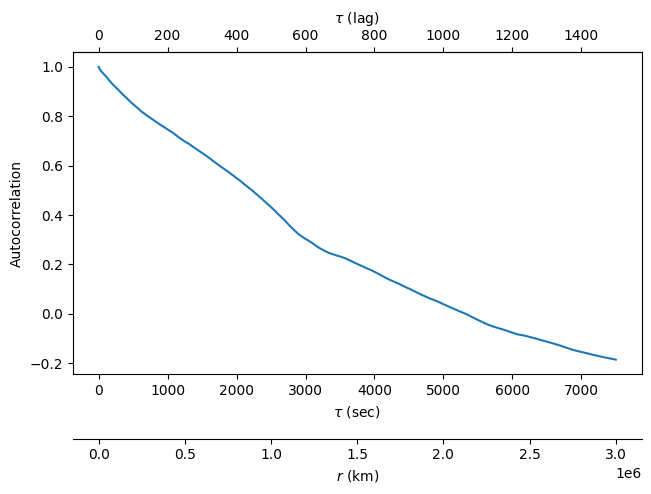

In [28]:
time_lags_lr, r_vec_lr = compute_nd_acf(
    np.array(
        [wind_df_lr.BGSE_0, wind_df_lr.BGSE_1, wind_df_lr.BGSE_2]), 
        nlags=1500, 
        dt=5, 
        show=True
        )


The following high-cadence, low $r$ ACF will be used for calculating the Taylor scale.

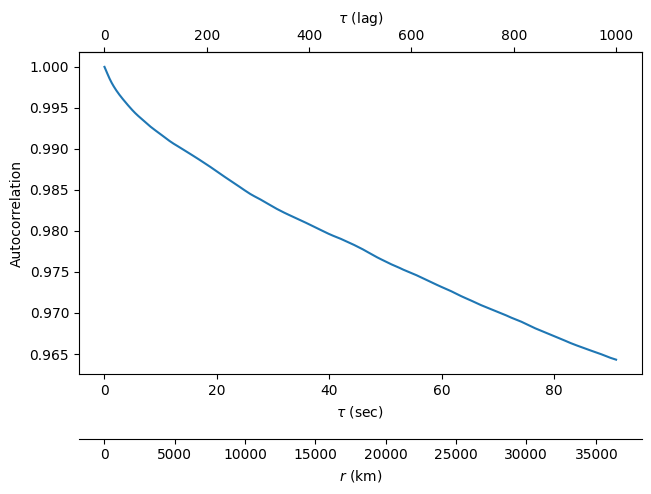

In [29]:
time_lags_hr, r_vec_hr = compute_nd_acf(
    np.array([
            wind_df_hr.BGSE_0, 
            wind_df_hr.BGSE_1, 
            wind_df_hr.BGSE_2
            ]), 
        nlags=1000, 
        dt = 0.091, 
        show = True)

### Correlation scale functions

Names for $\tau_c$:
- Outer scale
- (Longitudinal) integral scale
- Correlation scale

Methods for calculating:
- 1/e trick
- Exponential fit
- Integration

Smith et al. (2001) used the 1/e trick method (which they call $e$-folding) and the integration method. In Appendix B of their paper, they show how the estimates by either method increase depending on the lag up to which you calculate the ACF.

Firstly, using Kevin's function (just with plotting functionality added) for computing outer scale using $1/e$ trick:

**If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.**

Kevin referred to the value calculated from this method in his analysis as `estimate` and `Correlation_timescale_est`.

In [30]:
# Already in utils
def compute_outer_scale_exp_trick(autocorrelation_x: np.ndarray, autocorrelation_y: np.ndarray, show = False):
    """
    computes the correlation scale through the "1/e" estimation method.
    autocorrelation_x assumed already in time scale
    """
    for i, j in zip(autocorrelation_y, autocorrelation_x):
        if i <= np.exp(-1):
            # print(i, j)
            idx_2 = np.where(autocorrelation_x == j)[0]
            idx_1 = idx_2 - 1
            x2 = autocorrelation_x[idx_2]
            x1 = autocorrelation_x[idx_1]
            y1 = autocorrelation_y[idx_1]
            y2 = autocorrelation_y[idx_2]
            x_opt = x1 + ((y1 - np.exp(-1))/(y1-y2))*(x2-x1)

            try:

                # Optional plotting
                if show == True:

                    dt = autocorrelation_x[1]-autocorrelation_x[0]

                    fig, ax = plt.subplots(constrained_layout=True)
                    ax.plot(autocorrelation_x, autocorrelation_y)
                    ax.set_xlabel('$\\tau$ (sec)')
                    ax.set_ylabel('Autocorrelation')

                    # For plotting secondary axes
                    def sec2lag(x):
                        return x / dt

                    def lag2sec(x):
                        return x * dt

                    secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
                    secax_x.set_xlabel('$\\tau$ (lag)')

                    def sec2km(x):
                        return x * 400

                    def km2sec(x):
                        return x / 400

                    # use of a float for the position:
                    secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
                    secax_x2.set_xlabel('$r$ (km)')

                    plt.axhline(np.exp(-1), color = 'black')
                    plt.axvline(x_opt[0], color = 'black')
                    plt.show()

                return round(x_opt[0], 3)


            except Exception:
                return 0

    # none found
    return -1

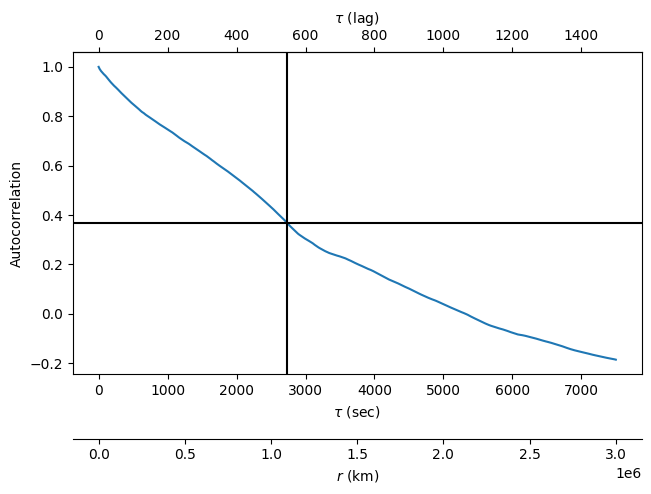

2734.607

In [31]:
compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, show = True)


What values should be expect? The lit review spreadsheet shows values in the range of $\lambda_C=$ 320,000 - 1,200,000km.

Secondly, adapting Kevin's function for computing outer scale using exponential fit, from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$


Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

<u>How to choose how much of the ACF to fit to?</u> Kevin used 1000 seconds, which was decided "through some trial and error and inspection of plotted results". While we should keep in mind that the correlation length will tend to increase with the maximum lag we fit to, I think we should fit to much more than 1000 seconds, as in the literature we see typical fits to 1-3,000,000km, corresponding to 2500-7500 seconds or 500-1500 lags. **Therefore, I have updated the pipeline to fit all the way up to 1500 lags (i.e. the entire low-res ACF).**

In [32]:
from utils import exp_fit

def compute_outer_scale_exp_fit(time_lags, acf, seconds_to_fit, show=False):

    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_c_fit = int(seconds_to_fit/dt)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], p0=1000)
    lambda_c = c_opt[0]


    # Optional plotting
    if show == True:

        fig, ax = plt.subplots()
        ax.plot(time_lags, acf, label = "Autocorrelation")
        ax.plot(
            np.array(range(int(seconds_to_fit))),
            exp_fit(
                np.array(range(int(seconds_to_fit))),
                *c_opt
            ),
            'r-', 
            label = "Exponential fit")
        
        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')
        ax.legend()
        plt.show()
    
    return lambda_c


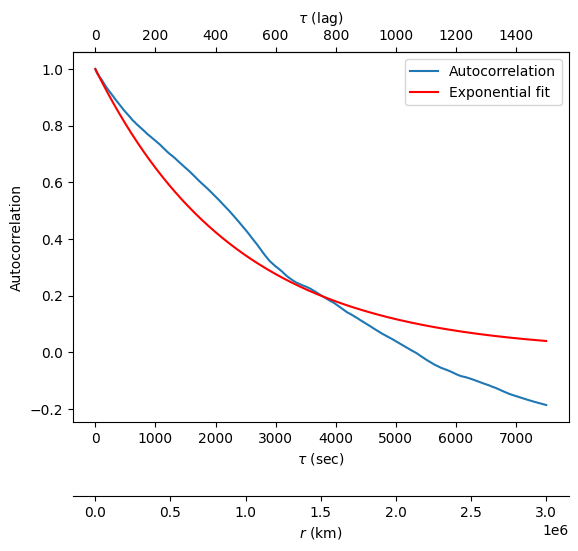

2331.2327210488806

In [33]:
compute_outer_scale_exp_fit(time_lags_lr, r_vec_lr, seconds_to_fit = time_lags_lr[-1], show = True)

Finally, creating a function for computing outer scale as integral of the ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970). 

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [34]:
def compute_outer_scale_integral(time_lags, acf, show=False):

    dt = time_lags[1]-time_lags[0]
    idx = np.argmin(np.abs(acf)) # Getting the index where the ACF falls to 0
    int = np.sum(acf[:idx])*dt # Computing integral up to that index

    # Optional plotting
    if show == True:
        fig, ax = plt.subplots()
        #ax.set_ylim(-.2, 1.2)
        ax.plot(time_lags, acf, label="Autocorrelation")
        ax.fill_between(time_lags, 0, acf, where=acf > 0)
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')

        plt.show()

    return int


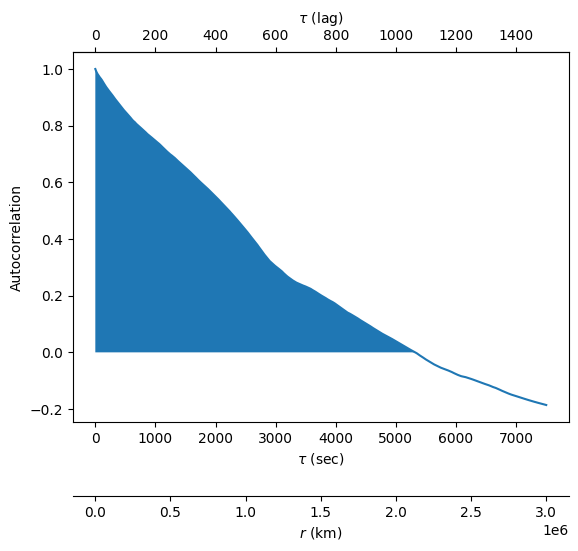

2278.0368102894413

In [35]:
compute_outer_scale_integral(time_lags_lr, r_vec_lr, show = True)

Isaacs et al. (2015) looked at the effect of **interval size** on the estimate of the correlation length, using data from ACE and comparing against the "true", multi-spacecraft value. The plots below line up quite well with the values calculated from our 6-hour intervals. In the accompanying discussion on pg10 of the paper, they state "averaging intervals of 10-20 hours appear to have a special significance with regard to computation of correlation scales."


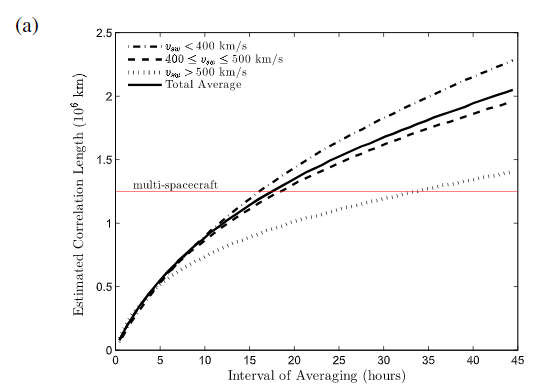

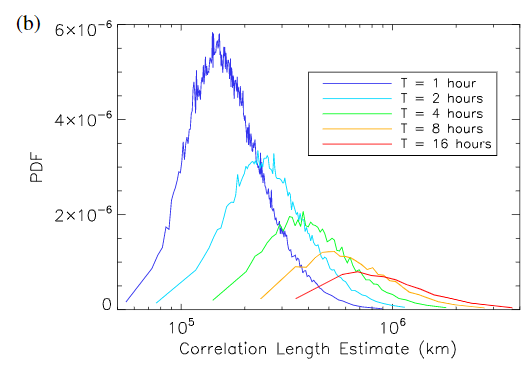

### Taylor scale function

Taylor microscale (time domain) = $\tau_{TS}$ = radius of curvature of ACF at the origin. 

Can calculate using second derivative of the ACF at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This code is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

In [36]:
from utils import para_fit

def compute_taylor_scale(time_lags, acf, tau_fit, show=False, show_intercept = False):
    """Compute the Taylor microscale

    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_fit: number of lags to fit the parabola over
    """

    # If using seconds_fit as the fitting argument instead:

    dt = time_lags[1]-time_lags[0]
    # tau_fit = int(seconds_fit/dt)

    t_opt, t_cov = curve_fit(
        para_fit,
        time_lags[:tau_fit],
        acf[:tau_fit],
        p0=10) # Initial guess for the parameters
    lambda_t = (-1*t_opt[0])**-.5

    extended_parabola_x = np.arange(0, 1.2*lambda_t, 0.1)
    extended_parabola_y = para_fit(extended_parabola_x, *t_opt)

    # Optional plotting
    if show == True:

        mpl_fig = plt.figure()
        fig, ax = plt.subplots()
        ax.scatter(time_lags, acf, label="Autocorrelation", s = 0.5)
        ax.plot(
            extended_parabola_x,
            extended_parabola_y,
            '-y',
            label="Parabolic fit")
        #plt.axhline(0, color = 'black')
        ax.axvline(0, color='green')
        ax.axvline(tau_fit*(time_lags[1]-time_lags[0]), color='green')

        ax.set_xlim(-0.2, tau_fit*dt*2)
        ax.set_ylim(0.99, 1.001)

        if show_intercept == True:
            ax.set_ylim(0, 1.05)
            ax.set_xlim(-2, lambda_t + 5)

        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')
        
        ax.legend()
        plt.show()

    return lambda_t


<Figure size 640x480 with 0 Axes>

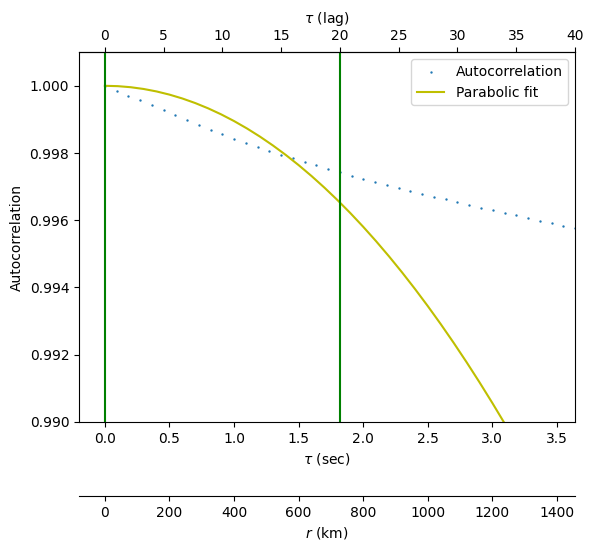

30.87655200409638

In [37]:
compute_taylor_scale(time_lags_hr, r_vec_hr, tau_fit=20, show = True, show_intercept=False)
# Set show_intercept = True if you want piece of mind that the value returned is actually the x-intercept

#### Chuychai (Richardson) extrapolation method

We can't just use the above function for some very small lag close to the origin, because as noted by Chuychai et al., "it is not practical to compute this limit because the data has a finite time resolution and there may be limited data available at the shortest time lags". Therefore, we can calculate the Taylor scale from a parabolic fit for a *range* of values of $\tau_{fit}$, up to $\tau_{max}$. Plot these values as a function of $\tau_{fit}$, then draw a straight line through the points back to $\tau_{fit}=0$. 

See lit review spreadsheet for ranges of $\tau_{fit}$ in other studies.

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{fit}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $\tau_{TS}^{extra}$: estimate obtained by the extrapolation method
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain) - point where the inertial range terminates and the spectrum steepens

<u>How do we choose the upper value, $\tau_{max}$?</u> This is investigated in Fig. 5 of Chuychai. Weygand et al. (2007) show an example of reaching a stable estimate as $\tau_{max}$ increases, but Chuychai shows that this is dependent on the spectral index. In particular, they note that we are more likely to reach a stable estimate of $\lambda_{TS}$ after extrapolation when we have a steep spectral index $q$ in the dissipation range. A smaller $q$ means we do not obtain a stable estimate.

**Here we have decided to set $\tau_{min}$ = 10 lags $\approx 1s $ and $\tau_{max}$= 50 lags $\approx 5s$.** This is roughly in line with what Chuychai & Matthaeus did for ACE data, while reducing $\tau_{max}$ due to understanding that we will not get convergence with increasing $\tau_{max}$ due to the relatively shallow values of $q$. This also matches their recommendation that a good estimate is obtained by an extrapolation of the curves evaluated near $\tau_{max}=\tau_d=4s$.

Chuychai et al. then developed an additional correction factor "which can be used when estimates of the [slope of the] high-frequency spectrum of the signal are available in some way, whether it be observations, theory, or an informed guess". The equation for this final estimate is given in Eq. 10 of the paper, and is coded into the following function.

In [38]:
def compute_taylor_chuychai(time_lags, acf, tau_min, tau_max, q=None, show=False):
    """Compute a refined estimate of the Taylor microscale using a linear extrapolation method from Chuychai et al. (2014).

    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_min: Minimum value for the upper lag to fit the parabola over. This should not be too small, because the data has finite time resolution and there may be limited data available at the shortest time lags. (You will see divergent behaviour if this happens.)
    - tau_max: Maximum value for the upper lag to fit the parabola over
    - q: Slope of the dissipation range
    """

    dt = time_lags[1]-time_lags[0]

    tau_fit = np.arange(tau_min, tau_max+1)
    tau_ts = np.array([])

    for i in tau_fit:
        lambda_t = compute_taylor_scale(time_lags, acf, tau_fit=i, show=False)
        tau_ts = np.append(tau_ts, lambda_t)

    # Performing linear extrapolation back to tau_fit = 0
    z, cov = np.polyfit(x=tau_fit, y=tau_ts, deg=1, cov=True)
    f = np.poly1d(z)

    ts_est_extra = z[1] # Extracting y-intercept
    
    # Getting standard deviation of y-intercept
    # (will plot +- 1 standard deviation)
    ts_est_extra_std = np.sqrt(cov[1,1])

    # Getting extrapolation line for plotting
    other_x = np.arange(0, tau_max+1)
    other_y = f(other_x)

    # Applying correction factor q from Chuychai et al. (2014)
    if q is not None:
        q_abs = np.abs(q)
        if q_abs < 2:
            r = -0.64*(1/q_abs)+0.72
        elif q_abs >= 2 and q_abs < 4.5:
            r = -2.61*(1/q_abs)+1.7
        elif q_abs >= 4.5:
            r = -0.16*(1/q_abs)+1.16

    else:
        r = 1

    ts_est = r*ts_est_extra 
    ts_est_std = r*ts_est_extra_std

    # Optional plotting
    if show == True:
        fig, ax = plt.subplots()
        ax.plot(tau_fit*dt, tau_ts, color="blue",
                 label="Range over which $\\tau_{TS}$ was calculated")
        ax.plot(other_x*dt, other_y, color="black",
                 label="Linear extrapolation to $\\tau_{fit}$=0", ls='--')
        if q is not None:
            ax.plot(0, ts_est, "go", label = "Final estimate with correction ratio applied (q={0:.2f})".format(q))
            #ax.plot(0, ts_est_final_lower, "r+", markersize=1)
            #ax.plot(0, ts_est_final_upper, "r+", markersize=1)
        ax.set_xlabel("$\\tau_{fit}$ (sec)")
        ax.set_ylabel("$\\tau_{fit}^{est}$ (sec)")

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, sec2lag))
        secax_x.set_xlabel('$\\tau_{fit}$ (lags)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r_{fit}$ (km)')
        
        plt.legend()
        plt.show()

    return ts_est, ts_est_std


We can compare the following to Fig. 4 in Chuychai, and less directly to Figs. 5 and 7 in Weygand et al. (2007)

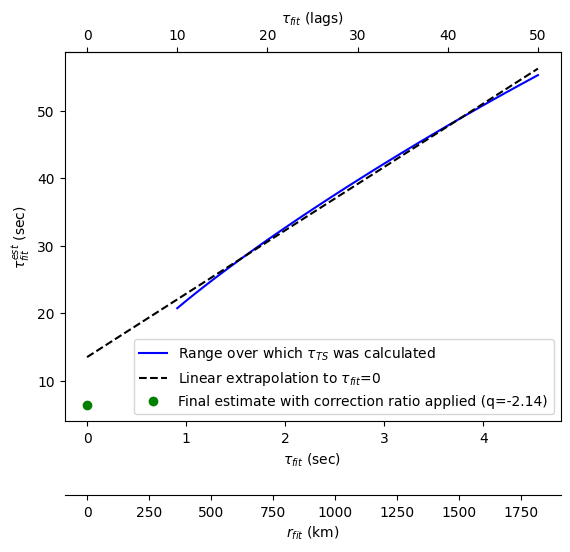

(6.498905415566012, 0.10992642290838002)

In [39]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=10, tau_max=50, q = -2.14, show = True)

In [40]:
# Meta-analysis: dependence on t_max. Takes ~ 4min to run

# tau_max_lower = 20
# tau_max_upper = 1000

# tau_fit_max = np.arange(tau_max_lower, tau_max_upper +1)
# tau_ts_meta = np.array([])

# for i in tau_fit_max:
#     ts_est_final = compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=10, tau_max=i, q = -2.14, show = False)
#     tau_ts_meta = np.append(tau_ts_meta, ts_est_final)

# plt.plot(tau_fit_max, tau_ts_meta)
# plt.xlabel("$\\tau_{max}$")
# plt.ylabel("$\\tau_{final}$")
# plt.show()

## Constructing the final dataframe

Currently have first two weeks of 2016 for each dataset available

In [41]:
# Splitting entire dataframe into a list of 6-hour intervals

# Below code, while possibly quicker (check) does not work for high-res intervals due to janky cadence. 
# Therefore doing loop-based split explicitly based on timestamps

# length_arr_lr = int(6*60*60*0.2)
# length_arr_hr = int(6*60*60*(1/0.091))

# n_intervals_lr = int(np.floor(len(large_wind_df_lr)/length_arr_lr))
# wind_df_lr_list = np.split(large_wind_df_lr[:n_intervals_lr*length_arr_lr], n_intervals_lr)

# n_intervals_hr = int(np.floor(len(large_wind_df_hr)/length_arr_hr))
# wind_df_hr_list = np.split(large_wind_df_hr[:n_intervals_hr*length_arr_hr], n_intervals_hr)

import datetime

wind_df_hr_list = []
wind_df_lr_list = []

start = pd.to_datetime("2016-01-01 00:00")
fin = pd.to_datetime("2016-01-01 06:00") 

for i in np.arange(0,56).tolist():
    wind_df_lr_list.append(large_wind_df_lr[start + datetime.timedelta(hours=i*6):fin + datetime.timedelta(hours=i*6)])
    wind_df_hr_list.append(large_wind_df_hr[start + datetime.timedelta(hours=i*6):fin + datetime.timedelta(hours=i*6)])

wind_df_lr_list[0]

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2016-01-01 00:00:00,14.960377,5.892269,-1.597420,-13.657980
2016-01-01 00:00:05,14.943271,5.893493,-1.596435,-13.638803
2016-01-01 00:00:10,14.942538,5.841498,-1.643213,-13.654799
2016-01-01 00:00:15,14.943983,5.867721,-1.650481,-13.644319
2016-01-01 00:00:20,14.927631,5.929097,-1.638702,-13.600977
...,...,...,...,...
2016-01-01 05:59:40,10.524644,3.976334,-9.700571,-0.918856
2016-01-01 05:59:45,10.293777,3.995200,-9.434019,-0.994201
2016-01-01 05:59:50,10.398553,4.259204,-9.458218,-0.699899


Note that annoyingly the split on the low-res dataframe includes an overlap of the last row in each interval with the first row in the next (i.e. one extra obs at the end of each that shouldn't be there). However this is very minor and will easily cancel out in the averaging, so I am not worried about it - and the high-res intervals do not have this problem (see below).

In [42]:
wind_df_hr_list[0]

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2016-01-01 00:00:00.000,14.943860,5.879855,-1.579370,-13.647411
2016-01-01 00:00:00.091,14.939990,5.890072,-1.591034,-13.637410
2016-01-01 00:00:00.182,14.915795,5.862018,-1.610130,-13.620763
2016-01-01 00:00:00.273,14.936459,5.875757,-1.632746,-13.634788
2016-01-01 00:00:00.364,14.943197,5.881089,-1.634825,-13.639622
...,...,...,...,...
2016-01-01 05:59:59.578,10.352386,4.167100,-9.432401,-0.914859
2016-01-01 05:59:59.669,10.335396,4.159393,-9.410312,-0.982792
2016-01-01 05:59:59.760,10.356019,4.168725,-9.420629,-1.058593


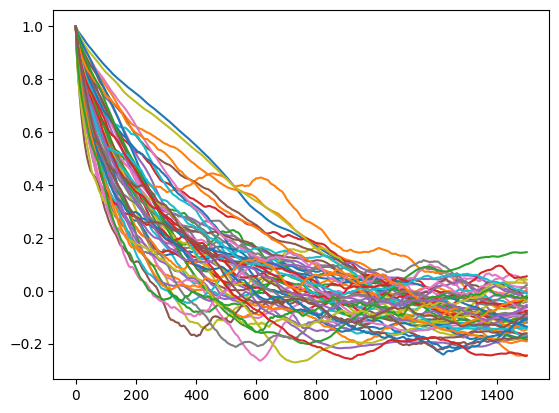

In [43]:
# Computing ACFs for each low-res interval
dt_lr = 5

acf_lr_list = []

for i in np.arange(len(wind_df_lr_list)):

    time_lags_lr, acf = compute_nd_acf(
        np.array([wind_df_lr_list[i].BGSE_0, wind_df_lr_list[i].BGSE_1, wind_df_lr_list[i].BGSE_2]), 
        nlags = 1500, 
        dt=dt_lr)

    acf_lr_list.append(acf)

for acf in acf_lr_list:
    plt.plot(acf)

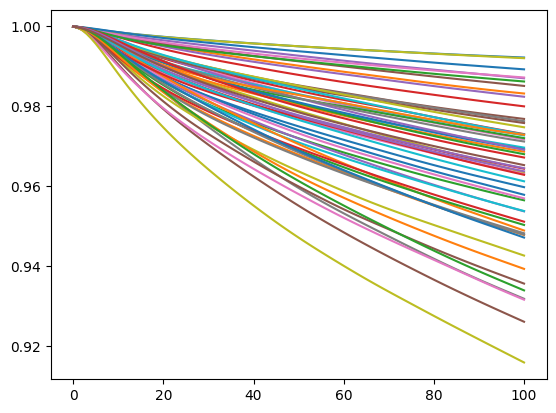

In [44]:
# Computing ACFs and spectral statistics for each high-res interval
# ~12s per interval due to spectrum smoothing algorithm

dt_hr = 0.091

acf_hr_list = []
inertial_slope_list = []
kinetic_slope_list = []
spectral_break_list = []

for i in np.arange(len(wind_df_hr_list)):

    time_lags_hr, acf = compute_nd_acf(
        np.array([
            wind_df_hr_list[i].BGSE_0,
            wind_df_hr_list[i].BGSE_1,
            wind_df_hr_list[i].BGSE_2
        ]),
        nlags=100,
        dt=dt_hr)

    acf_hr_list.append(acf)

    slope_i, slope_k, break_s = compute_spectral_stats(
        np.array([
            wind_df_hr_list[i].BGSE_0,
            wind_df_hr_list[i].BGSE_1, 
            wind_df_hr_list[i].BGSE_2
        ]),
        dt=dt_hr,
        f_min_inertial=0.01, f_max_inertial=0.2,
        f_min_kinetic=0.5, f_max_kinetic=2,
        show=False)

    inertial_slope_list.append(slope_i)
    kinetic_slope_list.append(slope_k)
    spectral_break_list.append(break_s)

for acf in acf_hr_list:
    plt.plot(acf)


In [45]:
# Computing scales for each interval

corr_scale_exp_fit_list = []
corr_scale_exp_trick_list = []
corr_scale_int_list = []

for acf in acf_lr_list:
    corr_scale_exp_fit = compute_outer_scale_exp_fit(
        time_lags_lr, acf, time_lags_lr[-1], show=False)
    corr_scale_exp_fit_list.append(corr_scale_exp_fit)

    corr_scale_exp_trick = compute_outer_scale_exp_trick(time_lags_lr, acf)
    corr_scale_exp_trick_list.append(corr_scale_exp_trick)

    corr_scale_int = compute_outer_scale_integral(time_lags_lr, acf)
    corr_scale_int_list.append(corr_scale_int)

# Re-calculating Kevin's values for checking against his results
taylor_scale_kevin_list = []

taylor_scale_list = []
taylor_scale_std_list = []

for i in range(len(acf_hr_list)):

    taylor_scale_kevin = compute_taylor_scale(
        time_lags_hr, 
        acf_hr_list[i], 
        tau_fit=20)
    taylor_scale_kevin_list.append(taylor_scale_kevin)

    taylor_scale, taylor_scale_std = compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[i],
        tau_min=10,
        tau_max=50,
        q=kinetic_slope_list[i])

    taylor_scale_list.append(taylor_scale)
    taylor_scale_std_list.append(taylor_scale_std)


In [46]:
# Joining lists of scales and spectral_stats together into a dataframe

df_1 = pd.DataFrame({
    'corr_scale_exp_fit': corr_scale_exp_fit_list,
    'corr_scale_exp_trick': corr_scale_exp_trick_list,
    'corr_scale_int': corr_scale_int_list,
    'taylor_scale': taylor_scale_list,
    'taylor_scale_std': taylor_scale_std_list,
    'taylor_scale_kevin': taylor_scale_kevin_list,
    'inertial_slope': inertial_slope_list,
    'kinetic_slope': kinetic_slope_list,
    'spectral_break': spectral_break_list
})


In [47]:
df_1.describe()

,corr_scale_exp_fit,corr_scale_exp_trick,corr_scale_int,taylor_scale,taylor_scale_std,taylor_scale_kevin,inertial_slope,kinetic_slope,spectral_break
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,1031.536909,1140.408196,999.290442,6.593869,0.050916,17.078054,-1.654229,-2.827632,0.253925
std,487.751318,662.340223,527.417649,1.130870,0.036113,4.803852,0.077371,0.343432,0.123962
min,364.880884,412.464000,35.405097,4.322983,0.007686,10.163716,-1.861564,-3.566933,0.015637
25%,679.441112,668.747250,688.429666,5.768962,0.023026,13.822106,-1.700766,-3.117399,0.173586
50%,944.838560,1019.624000,975.744157,6.609731,0.040092,16.218408,-1.640146,-2.806381,0.239322
75%,1194.616199,1252.078000,1243.361269,7.189587,0.065564,18.465303,-1.611764,-2.561508,0.324747
max,2331.232721,3455.319000,2278.036810,9.377364,0.170374,30.876552,-1.475899,-2.053126,0.578793


Let's use the min, median and max values of the **correlation scale (exp fit method)** to evaluate the current settings of the exponential fit function

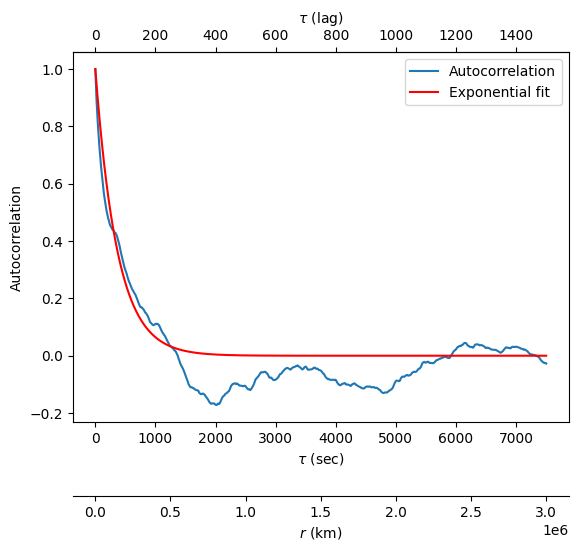

364.88088413910003

In [48]:
# Smallest corr scale calculated with fit method
compute_outer_scale_exp_fit(
        time_lags=time_lags_lr,
        acf=acf_lr_list[df_1.index[df_1["corr_scale_exp_fit"]==df_1["corr_scale_exp_fit"].min()][0]],
        seconds_to_fit=time_lags_lr[-1],
        show=True)

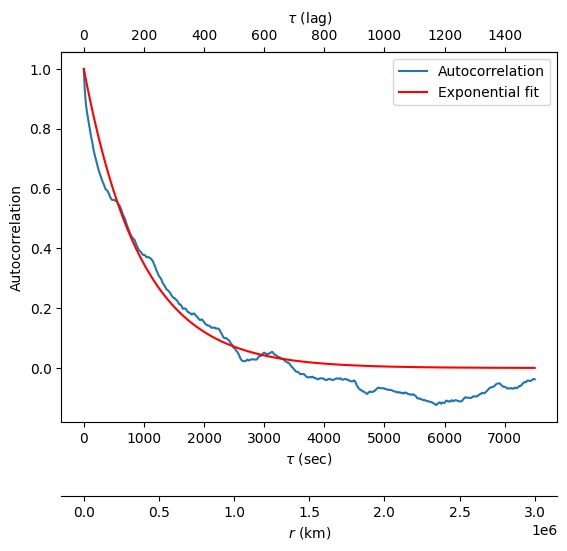

946.7139546280455

In [49]:
# Median corr scale calculated with fit method

median_ish = df_1.sort_values("corr_scale_exp_fit").reset_index()["corr_scale_exp_fit"][28]

compute_outer_scale_exp_fit(
        time_lags=time_lags_lr,
        acf=acf_lr_list[df_1.index[df_1["corr_scale_exp_fit"]==median_ish][0]],
        seconds_to_fit=time_lags_lr[-1],
        show=True)

We see in the plot above a very nice exponential shape to the ACF

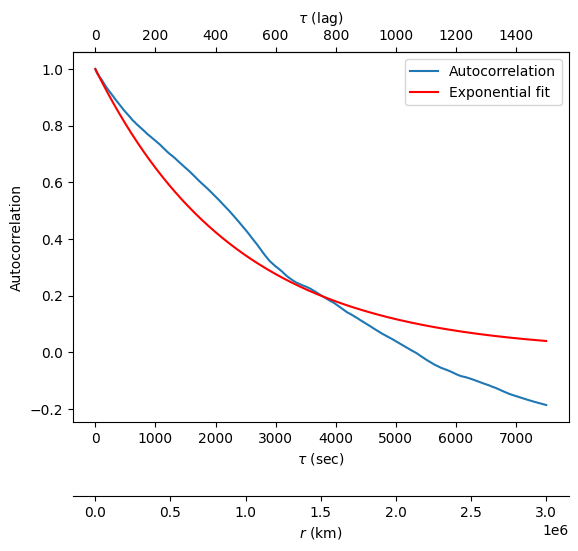

2331.2327210488806

In [50]:
# Largest corr scale calculated with fit method

compute_outer_scale_exp_fit(
        time_lags=time_lags_lr,
        acf=acf_lr_list[df_1.index[df_1["corr_scale_exp_fit"]==df_1["corr_scale_exp_fit"].max()][0]],
        seconds_to_fit=time_lags_lr[-1],
        show=True)

Let's use the min, median, and max values of the **Taylor scale** to evaluate the current settings of the estimation function

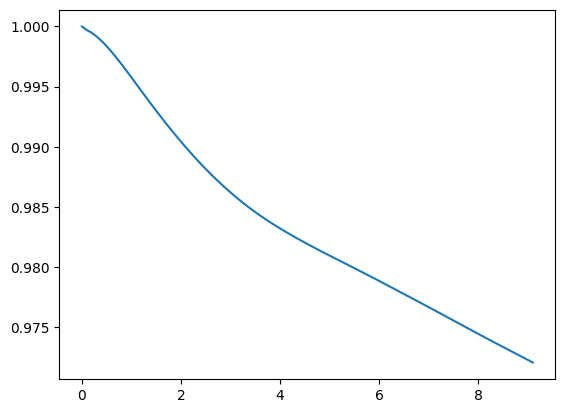

In [51]:
# ACF of the smallest Taylor scale calculated

plt.plot(time_lags_hr,acf_hr_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].min()][0]])
# plt.show()

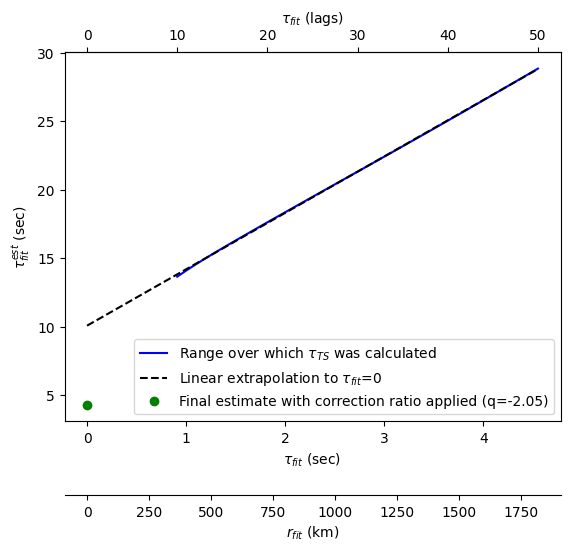

(4.322982581880303, 0.007685818576309981)

In [52]:
# Smallest Taylor scale calculated

compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].min()][0]],
        tau_min=10,
        tau_max=50,
        q=kinetic_slope_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].min()][0]],
        show=True)

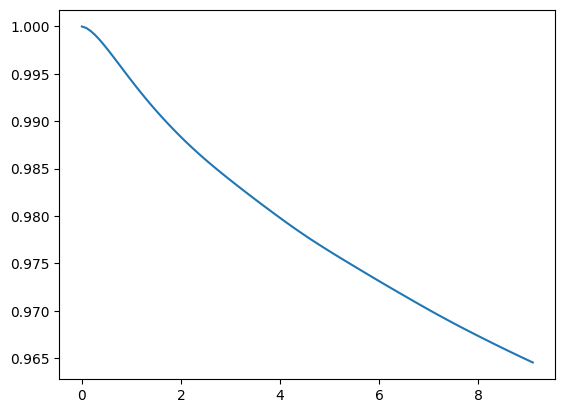

In [53]:
# ACF of the median Taylor scale calculated

median_ish = df_1.sort_values("taylor_scale").reset_index()["taylor_scale"][28]

plt.plot(time_lags_hr, acf_hr_list[df_1.index[df_1["taylor_scale"]==median_ish][0]])
plt.show()

We can see in the above plot a nice parabolic shape near the origin.

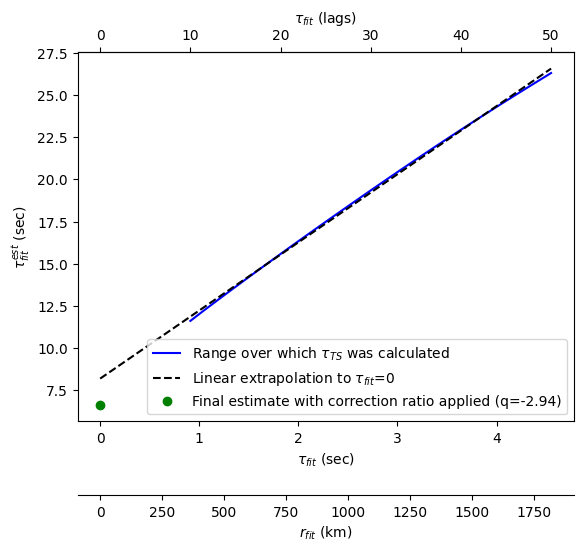

(6.623975460295374, 0.04279329533095847)

In [54]:
# Median Taylor scale calculated

compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[df_1.index[df_1["taylor_scale"]==median_ish][0]],
        tau_min=10,
        tau_max=50,
        q=kinetic_slope_list[df_1.index[df_1["taylor_scale"]==median_ish][0]],
        show=True)

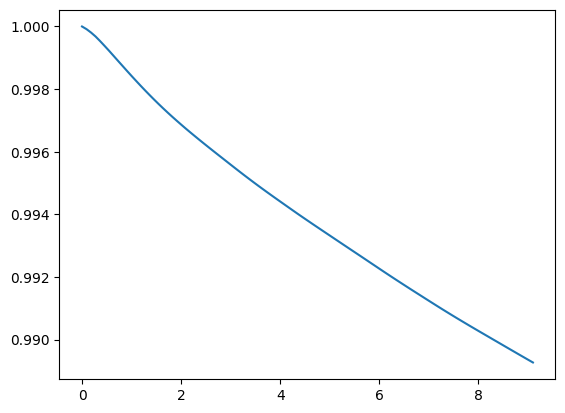

In [55]:
# ACF of the largest Taylor scale calculated

plt.plot(time_lags_hr, acf_hr_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].max()][0]])
plt.show()

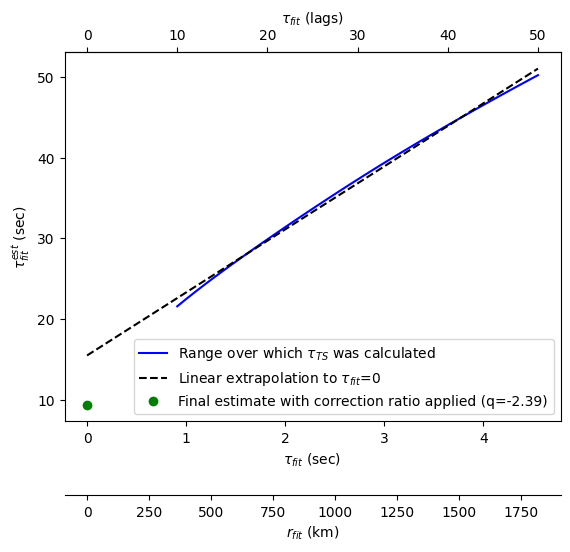

(9.37736378066131, 0.11316937437815817)

In [56]:
# Largest Taylor scale calculated

compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].max()][0]],
        tau_min=10,
        tau_max=50,
        q=kinetic_slope_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].max()][0]],
        show=True)

<u>In the following should I be multiplying by the individual flow speed, or by the overall avg (415)?</u>

In [57]:
# Joining other data together into a dataframe
df_2 = join_dataframes_on_timestamp(df_omni, df_electrons)
df_3 = join_dataframes_on_timestamp(df_2, df_protons)
df_4 = join_dataframes_on_timestamp(df_3, turb_fluc_hr)
df_5 = df_4.reset_index()

# Joining all data together into a dataframe, calculating taylor scale length and std deviation
df_complete = df_5.join(df_1)
df_complete["taylor_scale_km"] = df_complete["taylor_scale"]*df_complete["flow_speed"]
df_complete["taylor_scale_std_km"] = df_complete["taylor_scale_std"]*df_complete["flow_speed"]
df_complete

,Timestamp,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field,electron_density_wind,electron_temperature,electron_velocity_0,...,corr_scale_exp_trick,corr_scale_int,taylor_scale,taylor_scale_std,taylor_scale_kevin,inertial_slope,kinetic_slope,spectral_break,taylor_scale_km,taylor_scale_std_km
0,2016-01-01 00:00:00,1.631000,36290.113281,440.639587,0.062431,0.637778,5.598134,0.636881,23.853952,-538.960938,...,2734.607,2278.036810,6.462768,0.109315,30.876552,-1.734406,-2.135323,0.355202,2847.751534,48.168594
1,2016-01-01 06:00:00,1.501792,93113.062500,433.807373,0.155681,0.567444,1.835941,1.245301,17.447899,-468.791870,...,2860.171,2136.441471,8.030693,0.108528,23.358224,-1.641679,-2.579368,0.265276,3483.773682,47.080203
2,2016-01-01 12:00:00,1.528361,65383.054688,413.849457,0.165069,0.526625,0.515656,1.306304,14.769058,-509.211945,...,1265.506,1059.262623,4.930268,0.024419,13.716818,-1.522549,-2.581868,0.176736,2040.388601,10.105705
3,2016-01-01 18:00:00,6.850236,67298.859375,428.879181,3.348236,2.582833,0.227733,3.724676,11.154364,-492.649567,...,1817.296,1725.656902,5.475736,0.066783,17.752187,-1.659660,-2.471877,0.273912,2348.429113,28.641899
4,2016-01-02 00:00:00,4.903958,37046.175781,435.607513,1.171292,1.856833,0.330308,3.297387,11.701526,-499.503906,...,1368.003,1139.760031,8.161991,0.150893,26.788870,-1.861564,-2.467012,0.567016,3555.424416,65.730254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2016-02-28 18:00:00,5.390903,59273.695312,361.706543,3.654194,1.412542,0.598154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2016-02-29 00:00:00,5.269903,39359.515625,355.795288,3.440500,1.334111,0.123405,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2016-02-29 06:00:00,6.217403,39258.429688,346.831116,3.285653,1.493681,0.449150,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2016-02-29 12:00:00,9.139459,31012.351562,333.160583,3.350082,2.030241,0.161462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# Saving final dataframe
df_complete.to_csv("data/processed/df_complete.csv", index=False)

# Making some plots

Reproducing the plot for PSP data from Phillips et al.

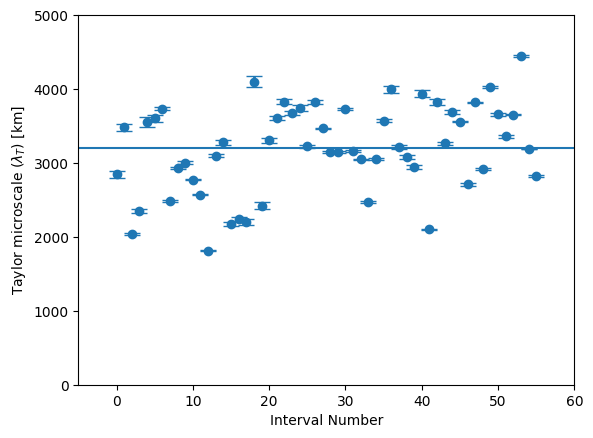

In [59]:
fig, ax = plt.subplots()

ax.errorbar(np.arange(len(df_complete)), df_complete.taylor_scale_km, yerr=df_complete.taylor_scale_std_km, fmt='o', linewidth=2, capsize=6)
ax.set(xlim=(-5, 60), ylim=(0, 5000))
plt.axhline(df_complete.taylor_scale_km.mean())
plt.ylabel("Taylor microscale ($\\lambda_T$) [km]")
plt.xlabel("Interval Number")
plt.show()

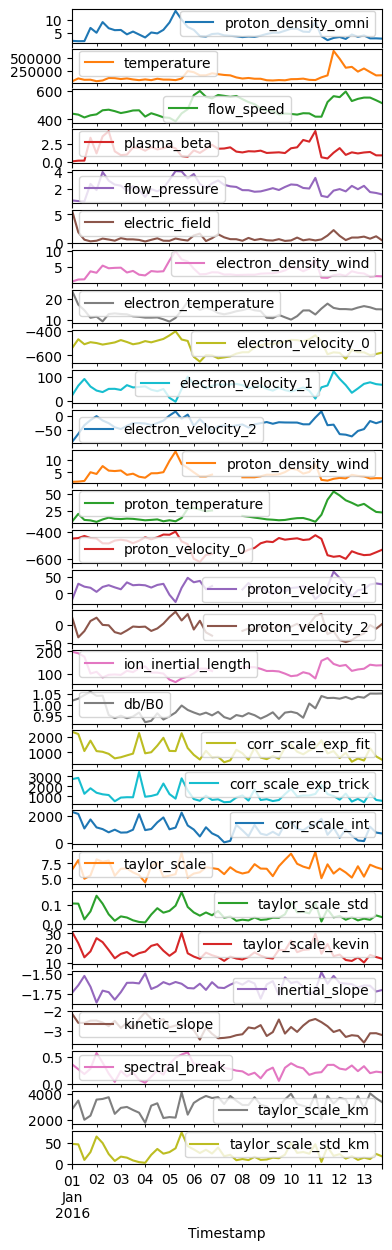

In [60]:
df_complete[df_complete["Timestamp"]<"2016-01-14"].plot(x = "Timestamp", subplots=True, figsize = (4, 15))
plt.show()

In [61]:
df_complete.taylor_scale_km.describe()

count      56.000000
mean     3195.654758
std       597.712165
min      1815.511786
25%      2841.147918
50%      3224.123853
75%      3660.161131
max      4445.272005
Name: taylor_scale_km, dtype: float64

## Correlation plots

Using R script

![title](corr_matrix_Rplot.png)

![title](corr_ranked_Rplot.png)

![title](corr_ranked_taylor_Rplot.png)

Alt matrix, if we want smart ordering of variables

![title](corr_matrix_Rplot_old.png)